In [1]:
import numpy as np 
import pandas as pd

import re
import string
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from sklearn.metrics import f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df_train = pd.read_csv("./labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df_train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
df_test=pd.read_csv("./testData.tsv", header=0, delimiter="\t", quoting=3)
df_test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [5]:
def data_cleaning(raw_data):
    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = raw_data.lower().split()
    stops = set(stopwords.words("english"))
    useful_words = [w for w in words if not w in stops]
    return( " ".join(useful_words))

df_train['review']=df_train['review'].apply(data_cleaning)
df_test["review"]=df_test["review"].apply(data_cleaning)

In [6]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

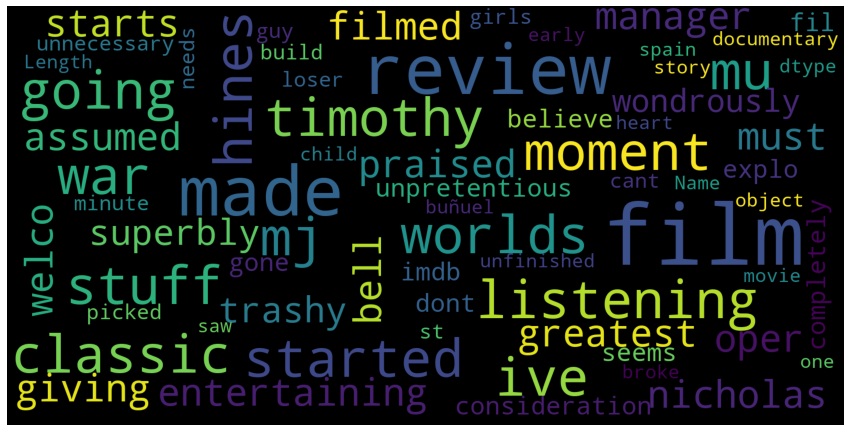

In [7]:
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(df_train["review"])

In [8]:
df_train.isnull().sum()
df_test.isnull().sum()

id        0
review    0
dtype: int64

In [9]:
import tensorflow as tf
# from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [10]:
y = df_train["sentiment"].values
train_reviews = df_train["review"]
test_reviews = df_test["review"]

In [11]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_reviews))
list_tokenized_train = tokenizer.texts_to_sequences(train_reviews)
list_tokenized_test = tokenizer.texts_to_sequences(test_reviews)

In [12]:
max_length = 360
X_train = pad_sequences(list_tokenized_train, maxlen=max_length)
X_test = pad_sequences(list_tokenized_test, maxlen=max_length)

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True

def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):    
    checkpoint_path = "./saved_weights"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    callbacks = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback]
    )
    return history

In [14]:
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## MODEL A

In [17]:
class Model_A():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        embed_size = 128
        x = Embedding(max_features, embed_size)(inp)
        x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(0.1)(x)
        x = Dense(50, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
        
        return model

model_a = Model_A()

In [18]:
print(model_a.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 360, 128)          768000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 360, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [19]:
model_a = Model_A()
history_a = train_model(model_a, "model_a", 5, 32, X_train, y, 0.2)

Epoch 1/5
32/32 [==============================] - 38s 174ms/step - loss: 0.6931 - accuracy: 0.5046 - val_loss: 0.6930 - val_accuracy: 0.5052

Epoch 00001: saving model to ./saved_weights
Epoch 2/5
32/32 [==============================] - 5s 156ms/step - loss: 0.6932 - accuracy: 0.5046 - val_loss: 0.6930 - val_accuracy: 0.5076

Epoch 00002: saving model to ./saved_weights
Epoch 3/5
32/32 [==============================] - 5s 160ms/step - loss: 0.6930 - accuracy: 0.5076 - val_loss: 0.6930 - val_accuracy: 0.5080

Epoch 00003: saving model to ./saved_weights
Epoch 4/5
32/32 [==============================] - 5s 157ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.5130

Epoch 00004: saving model to ./saved_weights
Epoch 5/5
32/32 [==============================] - 5s 155ms/step - loss: 0.6930 - accuracy: 0.5123 - val_loss: 0.6930 - val_accuracy: 0.5158

Epoch 00005: saving model to ./saved_weights


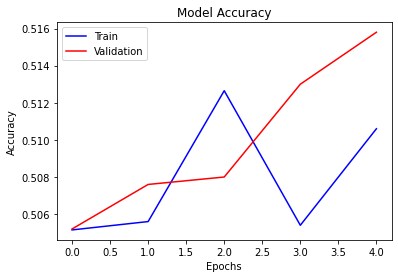

In [20]:
generate_graph(history_a)

In [21]:
class Model_B():
    def __new__(self):
        inp = Input(shape=(max_length, ))
        x = Embedding(max_features, 128)(inp)
        x = SpatialDropout1D(0.25)(x)
        x = LSTM(50, dropout=0.5, recurrent_dropout=0.5)(x)
        x = Dropout(0.5)(x)
        x = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
        return model
    
model_b = Model_B()

In [22]:
print(model_b.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 360)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 360, 128)          768000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 360, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                35800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 803,851
Trainable params: 803,851
Non-trainable params: 0
_____________________________________________________

In [23]:
model_b = Model_B()
history_b = train_model(model_b, "model_b", 5, 64, X_train, y, 0.2)

Epoch 1/5
64/64 [==============================] - 89s 1s/step - loss: 0.6498 - accuracy: 0.6165 - val_loss: 0.3787 - val_accuracy: 0.8312

Epoch 00001: saving model to ./saved_weights
Epoch 2/5
64/64 [==============================] - 87s 1s/step - loss: 0.3204 - accuracy: 0.8742 - val_loss: 0.3204 - val_accuracy: 0.8708

Epoch 00002: saving model to ./saved_weights
Epoch 3/5
64/64 [==============================] - 87s 1s/step - loss: 0.2511 - accuracy: 0.9109 - val_loss: 0.3645 - val_accuracy: 0.8694

Epoch 00003: saving model to ./saved_weights
Epoch 4/5
64/64 [==============================] - 87s 1s/step - loss: 0.2080 - accuracy: 0.9266 - val_loss: 0.3488 - val_accuracy: 0.8754

Epoch 00004: saving model to ./saved_weights
Epoch 5/5
64/64 [==============================] - 87s 1s/step - loss: 0.1861 - accuracy: 0.9373 - val_loss: 0.3505 - val_accuracy: 0.8742

Epoch 00005: saving model to ./saved_weights


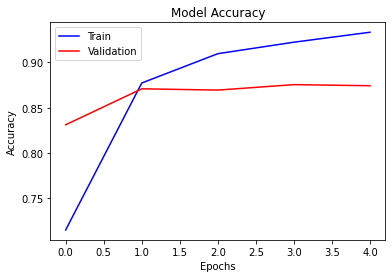

In [24]:
generate_graph(history_b)

In [29]:
class Model_C():
  def __new__(self):
    embed_size = 128
    model = Sequential()
    model.add(Embedding(max_features, embed_size))
    model.add(Bidirectional(LSTM(32, return_sequences = True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.05))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    
model_c = Model_C()

In [30]:
print(model_c.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                1300      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 810,537
Trainable params: 810,537
Non-trainable params: 0
________________________________________________

In [31]:
model_c = Model_C()
history_c = train_model(model_c, "model_c", 15, 64, X_train, y, 0.2)

Epoch 1/15
64/64 [==============================] - 10s 114ms/step - loss: 0.6475 - accuracy: 0.6503 - val_loss: 0.3984 - val_accuracy: 0.8300

Epoch 00001: saving model to ./saved_weights
Epoch 2/15
64/64 [==============================] - 7s 102ms/step - loss: 0.2987 - accuracy: 0.8803 - val_loss: 0.3100 - val_accuracy: 0.8738

Epoch 00002: saving model to ./saved_weights
Epoch 3/15
64/64 [==============================] - 7s 102ms/step - loss: 0.2064 - accuracy: 0.9226 - val_loss: 0.3171 - val_accuracy: 0.8740

Epoch 00003: saving model to ./saved_weights
Epoch 4/15
64/64 [==============================] - 7s 103ms/step - loss: 0.1567 - accuracy: 0.9460 - val_loss: 0.3236 - val_accuracy: 0.8694

Epoch 00004: saving model to ./saved_weights
Epoch 5/15
64/64 [==============================] - 7s 104ms/step - loss: 0.1254 - accuracy: 0.9588 - val_loss: 0.3527 - val_accuracy: 0.8656

Epoch 00005: saving model to ./saved_weights
Epoch 6/15
64/64 [==============================] - 7s 104m

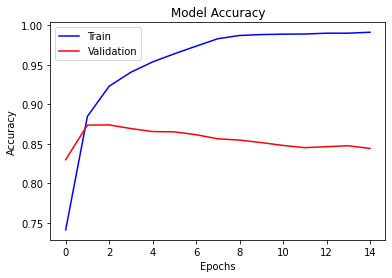

In [32]:
generate_graph(history_c)

In [33]:
model_c_1 = Model_C()
history_c_1 = train_model(model_c_1, "model_c", 3, 256, X_train, y, 0.2)

Epoch 1/3
256/256 [==============================] - 16s 52ms/step - loss: 0.5536 - accuracy: 0.7200 - val_loss: 0.3238 - val_accuracy: 0.8628

Epoch 00001: saving model to ./saved_weights
Epoch 2/3
256/256 [==============================] - 12s 48ms/step - loss: 0.2298 - accuracy: 0.9133 - val_loss: 0.3230 - val_accuracy: 0.8734

Epoch 00002: saving model to ./saved_weights
Epoch 3/3
256/256 [==============================] - 12s 46ms/step - loss: 0.1666 - accuracy: 0.9392 - val_loss: 0.3252 - val_accuracy: 0.8710

Epoch 00003: saving model to ./saved_weights


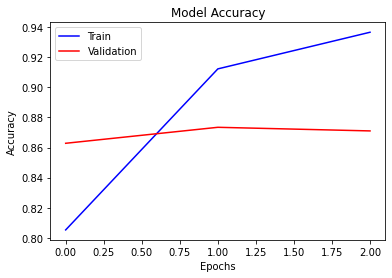

In [34]:
generate_graph(history_c_1)

In [35]:
class Model_D():
  def __new__(self):
    embed_size = 64
    model = Sequential()
    model.add(Embedding(max_features, embed_size))
    model.add(LSTM(16, return_sequences = True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model_d = Model_D()

In [36]:
print(model_d.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 64)          384000    
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 16)          5184      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 389,473
Trainable params: 389,473
Non-trainable params: 0
________________________________________________

In [37]:
model_d = Model_D()
history_d = train_model(model_d, "model_d", 10, 32, X_train, y, 0.2)

Epoch 1/10
32/32 [==============================] - 4s 98ms/step - loss: 0.6900 - accuracy: 0.5462 - val_loss: 0.6655 - val_accuracy: 0.7180

Epoch 00001: saving model to ./saved_weights
Epoch 2/10
32/32 [==============================] - 3s 82ms/step - loss: 0.6171 - accuracy: 0.7463 - val_loss: 0.4905 - val_accuracy: 0.8092

Epoch 00002: saving model to ./saved_weights
Epoch 3/10
32/32 [==============================] - 3s 82ms/step - loss: 0.4678 - accuracy: 0.8374 - val_loss: 0.4390 - val_accuracy: 0.8202

Epoch 00003: saving model to ./saved_weights
Epoch 4/10
32/32 [==============================] - 3s 83ms/step - loss: 0.3993 - accuracy: 0.8598 - val_loss: 0.4086 - val_accuracy: 0.8360

Epoch 00004: saving model to ./saved_weights
Epoch 5/10
32/32 [==============================] - 3s 82ms/step - loss: 0.3428 - accuracy: 0.8862 - val_loss: 0.3866 - val_accuracy: 0.8376

Epoch 00005: saving model to ./saved_weights
Epoch 6/10
32/32 [==============================] - 3s 82ms/step 

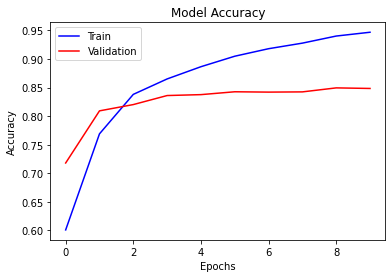

In [38]:
generate_graph(history_d)

In [39]:
def predict(model):
  prediction = model.predict(X_test)
  y_pred = (prediction > 0.5)

  df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
  y_test = df_test["sentiment"]

  cf_matrix = confusion_matrix(y_pred, y_test)
  f1_score_calc = cf_matrix[0][0] / (cf_matrix[0][0] + 0.5 * (cf_matrix[0][1] + cf_matrix[1][0]))
  print('F1-score: %.3f' % f1_score_calc)
  print("Confusion Matrix : ", cf_matrix)


In [40]:
predict(model_a)

F1-score: 0.511
Confusion Matrix :  [[6334 5977]
 [6166 6523]]


In [41]:
predict(model_b)

F1-score: 0.866
Confusion Matrix :  [[11052  1975]
 [ 1448 10525]]


In [42]:
predict(model_c)

F1-score: 0.840
Confusion Matrix :  [[10782  2375]
 [ 1718 10125]]


In [43]:
predict(model_c_1)

F1-score: 0.867
Confusion Matrix :  [[10875  1716]
 [ 1625 10784]]


In [44]:
predict(model_d)

F1-score: 0.837
Confusion Matrix :  [[10440  2002]
 [ 2060 10498]]


In [57]:
from sklearn.ensemble import RandomForestClassifier

model_random_forest = RandomForestClassifier(n_estimators = 300, random_state=45, bootstrap = "False", criterion="gini", min_samples_split = 10, min_samples_leaf = 1)
model_random_forest.fit(X_train, y)

RandomForestClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)

In [58]:
predict(model_random_forest)

F1-score: 0.555
Confusion Matrix :  [[7116 6019]
 [5384 6481]]


In [59]:
knn_list = []
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors = 54, weights = "uniform", metric = "euclidean" )
knn1.fit(X_train, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=54, p=2,
                     weights='uniform')

In [60]:
predict(knn1)

F1-score: 0.583
Confusion Matrix :  [[8623 8451]
 [3877 4049]]
